In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import scipy.io
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# dataPath = r'/Users/hyx020222/Documents/GitHub/Passive-Handwriting-Tracking/data'
dataPath = r'D:\Github\Passive-Handwriting-Tracking\data'
shapeType = 'three'
shapePath = fr'{dataPath}/{shapeType}'
movPath = fr'{shapePath}/{shapeType}.mov'
matPath = fr'{shapePath}/{shapeType}.mat'

In [3]:
def extract_added_black_points(path):
    cap = cv2.VideoCapture(path)

    # 读取第一帧
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    added_black_points_sequence = []

    while True:
        # 读取下一帧
        ret, frame = cap.read()
        if not ret:
            break

        # 转换为灰度图
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 计算相邻帧的差异
        diff = cv2.absdiff(prev_gray, gray)

        # 通过阈值化得到黑点
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # 查找轮廓
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 提取新增黑点的坐标
        added_points = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 5:  # 考虑面积大于5的轮廓为新增黑点
                M = cv2.moments(contour)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                added_points.append((cx, cy))

        added_black_points_sequence.append(added_points)

        # 更新上一帧
        prev_gray = gray

    cap.release()
    return added_black_points_sequence

In [4]:
sequence = extract_added_black_points(movPath)

# 删除空时刻
sequence = [points for points in sequence if points]

In [5]:
### Transform tuple into list ###
pointList = []

cnt = 0
for points in tqdm(sequence):
    xThis, yThis = zip(*points)
    xThis = int(xThis[0])
    yThis = int(yThis[0])

    # Check if this point is abnormally far from last point
    if cnt > 0:
        xLast = pointList[-1][0]
        yLast = pointList[-1][1]
        if math.sqrt((xThis - xLast)**2 + (yThis - yLast)**2) > 50:
            continue

    pointList.append([xThis, yThis])

    cnt += 1

# 提取 x 和 y 坐标
xPoint, yPoint = zip(*pointList)

100%|██████████| 166/166 [00:00<00:00, 75540.25it/s]


In [ ]:
### Rotate for pi ###
# 将点列表转换为NumPy数组以便于计算
pointArray = np.array(pointList)

# 计算重心
centroid = np.mean(pointArray, axis=0)
# 将每个点相对于重心进行旋转180度
rotated_points = 2 * centroid - pointArray

# 绘制旋转后的时序曲线
xPoint, yPoint = rotated_points.T

In [7]:
# 读取.mat文件
matData = scipy.io.loadmat(matPath)

# 获取.mat文件中的变量
matData = matData['rotated']
# 转换成pointList的格式
matData = matData.T.tolist()

# 提取 x 和 y 坐标
xMat, yMat = zip(*matData)

In [8]:
### Scale ground truth to the same size as estimated ###
min_x_rotated, max_x_rotated = min(xPoint), max(xPoint)
min_y_rotated, max_y_rotated = min(yPoint), max(yPoint)

min_xMat, max_xMat = min(xMat), max(xMat)
min_yMat, max_yMat = min(yMat), max(yMat)

# 缩放 x_rotated 和 y_rotated 到 xMat 和 yMat 的大小范围
xScaled = [min_xMat + (x - min_x_rotated) / (max_x_rotated - min_x_rotated) * (max_xMat - min_xMat) for x in xPoint]
yScaled = [min_yMat + (y - min_y_rotated) / (max_y_rotated - min_y_rotated) * (max_yMat - min_yMat) for y in yPoint]

In [9]:
# 将 xScaled 和 yScaled 线性插值到与 xMat 和 yMat 长度相等
interp_func_x = interp1d(np.linspace(0, 1, len(xScaled)), xScaled, kind='linear')
interp_func_y = interp1d(np.linspace(0, 1, len(yScaled)), yScaled, kind='linear')

# 生成新的 x 和 y
xPoint = interp_func_x(np.linspace(0, 1, len(xMat)))
yPoint = interp_func_y(np.linspace(0, 1, len(yMat)))

print(len(xPoint), len(yPoint), len(xMat), len(yMat))

306 306 306 306


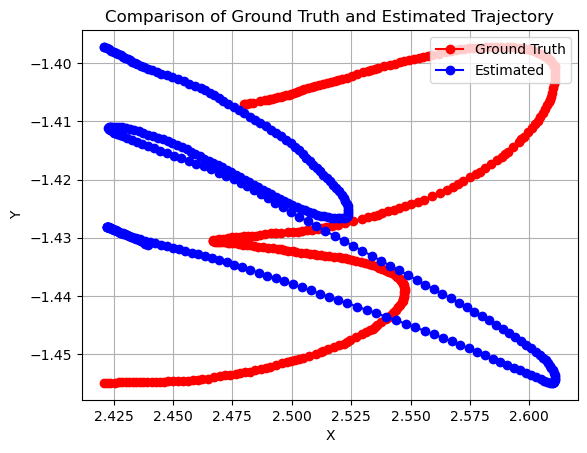

In [10]:
### Plot figure to compare ###
fig, ax = plt.subplots()

plt.plot(xPoint, yPoint, 
         marker='o', 
         linestyle='-', 
         color='r',
         label='Ground Truth')

plt.plot(xMat, yMat, 
         marker='o', 
         linestyle='-', 
         color='b',
         label='Estimated')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Comparison of Ground Truth and Estimated Trajectory')
ax.grid(True)
# ax.axes.set_aspect('equal')
ax.legend(loc='upper right')

plt.show()

Text(0.5, 1.0, 'CDF of Distance')

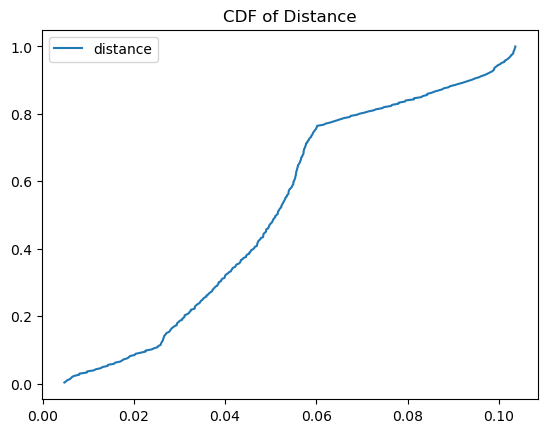

In [11]:
### Draw CDF ###
distance = [math.sqrt((xPoint[i] - xMat[i])**2 + (yPoint[i] - yMat[i])**2) for i in range(len(xPoint))]
ecdf = ECDF(distance)

plt.plot(ecdf.x, ecdf.y, 
         label='distance')

plt.legend(loc='upper left')
plt.title('CDF of Distance')
